In [1]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
import pandas as pd
from langchain import PromptTemplate
import re
import matplotlib.pyplot as plt
from prompt_templates import *
import torch
import random
import warnings
import numpy as np
warnings.filterwarnings('ignore')


In [28]:
MODEL_PATH = {#"Gemma-7b-it" : "../models/gemma-7b-it.gguf",
              "Mixtral-8x-7b": "../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf",
               "Phi-2": "../models/phi-2.Q5_K_M.gguf",
               #"Llama2-70b": "../models/llama2_70b_chat_uncensored.Q5_K_M.gguf",
               #"Yi-34b": "../models/yi-34b-200k.Q5_K_M.gguf",
               #"Dolphin-2.5": "../models/dolphin-2.5-mixtral-8x7b.Q5_K_M.gguf",
              }

#Set output file name
OUTPUT_PICKEL = "../data/llm_prob_result_10.pkl"

MAX_SAMPLING_RATE = 5

#Set to 1 if you dont want to shuffle

NUM_OF_SHUFFLES = 5

FEW_SHOT_TEMPLATE = """
    The following are multiple choice questions (with answers) about network fundamentals, network access,
    security fundamentals, automation and programmability. Here is an example
    
    Question: Which two options are the best reasons to use an IPV4 private IP space? (Choose two.)
    
    Choices:
    A. to enable intra-enterprise communication
    B. to implement NAT
    C. to connect applications
    D. to conserve global address space
    E. to manage routing overhead
                                               
    Correct Answer: ['A','D']
    
    Please give the answer in the following format:
        Correct Answer: ['A','D']           
    
    Now, answer the following question:
    Question: {Exam_Question}        
                    
    Choices:
    {Exam_Choices}
    """

SHUFFLE_PROB_ENB = False
SHUFFLE_ONLY =True

In [29]:
def extract_answer(answer):
    """Extracts the correct answers from the provided answer string.

    Args:
        answer: The answer string to extract the correct answers from.

    Returns:
        A list of correct answers (e.g., ['A', 'B']) if found, otherwise None. 
    """

    pattern = r"""
        ^\s*                
        Correct\s+Answer:\s+  
        \[                  
        ['ABCDET\s,]+      
        \]                  
        \s*                 
    """
    match = re.search(pattern, answer, flags=re.VERBOSE)
    if match:
        # Extract the answer portion within the brackets
        answer_section = match.group(0).split('[')[1].split(']')[0]

        # Find individual answers (consider making this more robust if needed)
        correct_answers = answer_section.strip().split(',')
        return [ans.strip().strip("'") for ans in correct_answers]

    else:
        return None

def compare_answers(answerLLM, answer_exam):
    """Compares the extracted correct answers with the answers in answer_exam.

    Keyword arguments:
    answerLLM -- the list of answers extracted from the LLM answer
    answer_exam -- list of answers from the exam
    """

    # Convert the answer_exam string to a list of answers
    answer_exam_list = answer_exam.split(" ")
    #Get number of correct answers in the exam
    num_of_correct_exam_answers = len(answer_exam_list)
    

    # Convert both lists to sets for efficient comparison
    answer_LLM_set = set(answerLLM)
    answer_exam_set = set(answer_exam_list)

    # Calculate the count of matching answers
    number_of_correct_llm_answers = len(answer_LLM_set.intersection(answer_exam_set))

    # Check if the number of answers given by the LLM is greater than the number of correct answers
    too_many_answ_given = False
    if len(answer_LLM_set) > num_of_correct_exam_answers:
        too_many_answ_given = True

    # Return a dictionary with the matching count and the number of correct answers
    return number_of_correct_llm_answers, too_many_answ_given

def evaluation_sampling(llm_answer, exam_Answers, num_of_correct_answer):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_answer(llm_answer)
    if answerLLM is not None:
        num_of_correct_llm_Answers, too_many_answ = compare_answers(answerLLM, exam_Answers)
        if num_of_correct_llm_Answers == num_of_correct_answer and too_many_answ == False:
            answered_correctly = True
        else:
            answered_correctly = False 
        return num_of_correct_llm_Answers, answerLLM, too_many_answ, answered_correctly
    else:
         return -1


#####
# Partial Credit allowed?
####
def evaluation(llm_output_dataframe):

    # Compute the number of total questions for each model
    number_of_questions = llm_output_dataframe.groupby('Model')['QuestionIndex'].count()
    
    #Number of fully correct answers given by the LLM
    correctly_answered = llm_output_dataframe.groupby('Model')['Answered_Correctly'].sum()

    #Number of incorrect answers given by the LLM
    incorrectly_answered = number_of_questions - correctly_answered

    #Amount of correct answers in the exam
    amount_correcct_exam_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectExamAnswers'].sum()

    #Amount of correct answers given by the LLM even if not fully correct
    amount_correcct_llm_answers = llm_output_dataframe.groupby('Model')['NumberOfCorrectLLMAnswers'].sum()
    
    #Calculation of Precision and Recall and f1 score
    precision = correctly_answered / number_of_questions
    precision_partial = amount_correcct_llm_answers / amount_correcct_exam_answers


    results_df = pd.DataFrame({
        'Number of Questions': number_of_questions,
        'Correctly Answered': correctly_answered,
        'Incorrectly Answered': incorrectly_answered,
        'Precision': precision,
        'Precision Partial': precision_partial,
    })

    results_df = results_df.reset_index()

    return results_df


def plot_evaluation(evaluation_df):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Precision' with std and mean
        - 'Precision Partial' with std and mean
    """

    # --- Subplot 1: Precision and Recall ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    bar_width = 0.35

    axs[0].bar(evaluation_df['Model'], evaluation_df['Precision'], bar_width, 
               label='Precision', color='#1f77b4')

    # Add percentages
    for i, row in evaluation_df.iterrows():
        axs[0].text(row['Model'], row['Precision'] + 0.01, f"{row['Precision']:.1%}", 
                    ha='center', color='black')

    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Percentage of Questions')
    axs[0].set_title('Precision and Recall', fontsize=12)
    axs[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)
    axs[0].legend()

    # --- Subplot 2: Partial Precision ---
    axs[1].bar(evaluation_df['Model'], evaluation_df['Precision Partial'], bar_width,
               label='Precision Partial', color='#2ca02c')

    # Add percentages
    for i, score in enumerate(evaluation_df['Precision Partial']):
        axs[1].text(i + bar_width / 2, score + 0.01, f"{score:.1%}", ha='center', color='black')

    axs[1].set_xlabel('Model')
    axs[1].set_ylabel('Precision Partial')
    axs[1].set_title('Precision Partial', fontsize=12)
    axs[1].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df))])
    axs[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=10)

    fig.tight_layout()
    plt.show()

def extract_answer_from_text_file(path_to_text_file):
   # Read the text file
    with open(path_to_text_file, 'r') as file:
        lines = file.readlines()

    # Initialize lists to store data
    questions = []
    answers = []
    correct_answers = []

    # Parse the lines
    question = ""
    options = ""
    correct_option = ""
    for line in lines:
        line = line.strip()
        if line.startswith("Question:"):
            if question:  # If it's not the first question
                questions.append(question)
                answers.append(options)
                correct_answers.append(correct_option)
                options = ""  # Reset options for the new question
            question = line.replace("Question:", "").strip()
        elif line.startswith("Answer:"):
            correct_option = line.split(":")[-1].strip()
        elif line.startswith(("A.", "B.", "C.", "D.", "E.", "F.", "G.")):
            options += line.strip() + " "  # Add options to the string

    # Append the last question
    questions.append(question)
    answers.append(options)
    correct_answers.append(correct_option)

    # Create a DataFrame
    data = {
        'Question': questions,
        'Answers': answers,
        'Correct Answer': correct_answers
    }

    df = pd.DataFrame(data)
    return df


def split_options_string(options_string):
    # Use regular expression to split the string
    options_list = re.split(r'(?=[A-Z]\.)', options_string)
    
    # Remove any leading or trailing whitespace from each option
    options_list = [option.strip() for option in options_list if option.strip()]
    
    return options_list

def format_options_string(options_list):
    # Join the options list with newline characters
    formatted_options_string = '\n'.join(options_list)
    
    return formatted_options_string


def evaluation_probability(char_prob_list, llm_answer, exam_answers, num_of_correct_answer):
    # Normalize probabilities
    total = sum(char_prob_list.values())
    for letter in char_prob_list:
        char_prob_list[letter] /= total


    # Sort characters by probability
    sorted_chars = sorted(char_prob_list.items(), key=lambda item: item[1], reverse=True)
    # Select answers based on the number of correct answers for the question
    answerLLm = [char for char, prob in sorted_chars[:num_of_correct_answer]]
    num_of_correct_llm_answer, too_many_answers = compare_answers(answerLLm, exam_answers)
    
    if num_of_correct_llm_answer == num_of_correct_answer and too_many_answers == False:
        answered_correctly = True
    else :
        answered_correctly = False
    return num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly

def extract_exam_info(examQuestion):
    #Extracting the question, answer and choices from the dataframe
    question = examQuestion[0].strip()  # Get the value of the first column (question) and remove leading/trailing whitespace
    answer_exam = examQuestion[2].strip()    # Get the value of the third column (answer) and remove leading/trailing whitespace
    answer_exam_with_whitespace = ' '.join(list(answer_exam))

    #Set the number of correct answers
    num_of_correct_answer = len([char for char in answer_exam_with_whitespace if char != ' '])

    #Create the choices string like in the prompt template
    choices = ""  # Reset the choices variable for each question
    choices = split_options_string(examQuestion[1])
    choices = format_options_string(choices)

    return question, choices, answer_exam_with_whitespace, num_of_correct_answer

def shuffle_choices(choices_string, answers):
    # Split the input string into a list of choices
    choices = re.split(r'\n', choices_string)
    
    # Create a dictionary to track the original and new letters of the choices
    letter_map = {}
    
    # Shuffle the list
    random.shuffle(choices)
    
    # Reassign the choice letters
    shuffled_string = ""
    for i, choice in enumerate(choices):
        original_letter = choice.split(". ", 1)[0]
        new_letter = chr(65 + i)
        shuffled_string += new_letter + ". " + choice.split(". ", 1)[1] + "\n"
        
        # Update the letter map
        letter_map[original_letter] = new_letter
    
    # Split the answers string into a list of answer letters
    answers = answers.split()
    
    # Update the answers
    new_answers = [letter_map[answer] for answer in answers]
    
    return shuffled_string.strip(), ' '.join(new_answers)

def calculate_model_statistics(df):
    """
    Calculates statistics for each model in the DataFrame.
    
    Args:
    df (DataFrame): Input DataFrame containing evaluation metrics for different models.
    
    Returns:
    DataFrame: New DataFrame containing calculated statistics for each model.
    """
    model_stats = []
    for model, group_df in df.groupby('Model'):
        model_stat = {
            'Model': model,
            'Precision Mean': group_df['Precision'].mean(),
            'Precision Max': group_df['Precision'].max(),
            'Precision Min': group_df['Precision'].min(),
            'Precision STD': group_df['Precision'].std(),
            'Precision Partial Mean': group_df['Precision Partial'].mean(),
            'Precision Partial Max': group_df['Precision Partial'].max(),
            'Precision Partial Min': group_df['Precision Partial'].min(),
            'Precision Partial STD': group_df['Precision Partial'].std()
        }
        model_stats.append(model_stat)
    
    return pd.DataFrame(model_stats)

In [30]:
# questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
# questions = questions.head(10)
# for index_question, row in questions.iterrows():
#     question, choices, answers, num_of_correct_answer = extract_exam_info(row)
#     print(question)
#     print(choices)
#     print(answers)
#     choices, answers = shuffle_choices(choices, answers)
#     print(choices)
#     print(answers)



In [31]:
valid_question_answer = False  
#Create a dataframe with the size of NUM_OF_SHUFFLES which contains the dataframe llm_exam_result
shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Precision','Precision Partial'])

questions = extract_answer_from_text_file("../data/questionbank_cisco_CCNP.txt")
questions = questions.head(10)
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
prompt_template = PromptTemplate.from_template(FEW_SHOT_TEMPLATE)

#Iterate over each model definied in the MODEL_PATH dictionary
for model, model_path in MODEL_PATH.items():
     #Load the model wiht LLamaCpp
    llm = LlamaCpp(
        model_path= model_path,
        n_gpu_layers=128,
        n_batch=512,
        #TEMPERATURE !! --> Temperature Sampling
        #max_tokens = 100,
        #callback_manager=callback_manager,
        verbose=False,  # Verbose is required to pass to the callback manager
    )

    chain = prompt_template | llm
    for shuffled_iteration in range(NUM_OF_SHUFFLES):
        llm_exam_result = pd.DataFrame(columns = ["Model", "QuestionIndex", "SamplingIndex", "NumberOfCorrectLLMAnswers", "NumberOfCorrectExamAnswers", "Ratio", "LLM_Answer", "Exam_Answers", "Answered_Correctly",  "Too_Many_answers"]) 
        #Iterate over each question in the question dataframe
        for index_question, row in questions.iterrows():
            #Extract the question, answer and choices from the dataframe
            question, choices, answers, num_of_correct_answer = extract_exam_info(row)
            print(question)
            print(choices)
            print(answers)
            print('\n')
            #Only if shuffle is enabled, shuffle the choices
            if shuffled_iteration > 0:
                choices, answers = shuffle_choices(choices, answers)
                print(question)
                print(choices)
                print(answers)
                print('\n')
            #Empty the char_probabilities dictionary for each question
            char_probabilities = {}

            #Iterate over the maximum sampling rate
            for index_sampling in range(MAX_SAMPLING_RATE):
                # Invoke the chain with the question and choices
                llm_answer = chain.invoke({"Exam_Question" : question, "Exam_Choices" : choices})            

                # Check if the answer is in the expected format
                if extract_answer(llm_answer) is not None:

                    #If probability is enabled, check what the correct answer is after all the sampling
                    if not SHUFFLE_PROB_ENB:
                        # Extract the correct answers from the LLM answer and analyse the answer
                        num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_sampling(llm_answer, answers, num_of_correct_answer)
                        #Save the current sampling index -- How of the question has been asked until the answer was in the correct format
                        sample_Index = index_sampling
                        valid_question_answer = True
                        break
                    else:
                        answer_letters = extract_answer(llm_answer)
                        sample_Index = index_sampling
                        valid_question_answer = True
                        #Shuffle the choices
                        choices = shuffle_choices(choices, answers)
                        for letter in answer_letters:
                            if letter in char_probabilities:
                                char_probabilities[letter] += 1
                            else:
                                char_probabilities[letter] = 1
            
            if SHUFFLE_PROB_ENB:
                num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly = evaluation_probability(char_probabilities, llm_answer, answers, num_of_correct_answer)
        
                        
            #Depending on the result of the answer, add the result to the dataframe
            if not valid_question_answer:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [-1], "NumberOfCorrectLLMAnswers": [0], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [-1], "LLM_Answer": [llm_answer], "Exam_Answers": [answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
            else:
                new_row = pd.DataFrame({"Model": [model], "QuestionIndex": [index_question], "SamplingIndex": [sample_Index], "NumberOfCorrectLLMAnswers": [num_of_correct_llm_answer], "NumberOfCorrectExamAnswers": [num_of_correct_answer], "Ratio": [num_of_correct_llm_answer/num_of_correct_answer], "LLM_Answer": [answerLLm], "Exam_Answers": [answers], "Answered_Correctly" : [answered_correctly], "Too_Many_answers": [too_many_answers]})
                llm_exam_result = pd.concat([llm_exam_result, new_row], ignore_index=True)
                valid_question_answer = False
        answered_correctly = False
        #Concat the the dataframe returned by evaulation to one dataframe
        display(llm_exam_result)
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
        display(shuffled_evalutation_df)

#plot_evaluation(shuffled_evalutation_df)
model_statistics = calculate_model_statistics(shuffled_evalutation_df)
display(model_statistics)

    #llm_exam_result.to_pickle(OUTPUT_PICKEL)


llama_model_loader: loaded meta data with 26 key-value pairs and 995 tensors from ../models/mixtral-8x7b-instruct-v0.1.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mixtral-8x7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:    

A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


An administrator can leverage which attribute to assign privileges based on Microsoft Active Directory user groups?
A. member of
B. group
C. class
D. person
A


Changes were made to the ISE server while troubleshooting, and now all wireless certificate authentications are failing. Logs indicate an EAP failure. What is the most likely cause of the problem?
A. EAP-TL

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,0,1,1,1.0,[A],A,True,False
1,Mixtral-8x-7b,1,0,0,1,0.0,[B],C,False,False
2,Mixtral-8x-7b,2,0,1,1,1.0,[A],A,True,False
3,Mixtral-8x-7b,3,0,0,1,0.0,"[B, E]",A,False,True
4,Mixtral-8x-7b,4,0,0,2,0.0,"[A, C]",D E,False,False
5,Mixtral-8x-7b,5,0,1,1,1.0,[A],A,True,False
6,Mixtral-8x-7b,6,1,1,1,1.0,[C],C,True,False
7,Mixtral-8x-7b,7,0,1,1,1.0,[A],A,True,False
8,Mixtral-8x-7b,8,0,1,1,1.0,[A],A,True,False
9,Mixtral-8x-7b,9,-1,0,3,-1.0,"\n Correct Answer: ['A','B','F']",B D F,NaN,NaN


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Generic LDAP
D. Windows Active Directory
A


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,1,1,1,1.000000,[A],A,True,False
1,Mixtral-8x-7b,1,0,1,1,1.000000,[D],D,True,False
2,Mixtral-8x-7b,2,0,0,1,0.000000,[C],D,False,False
3,Mixtral-8x-7b,3,0,0,1,0.000000,[B],E,False,False
4,Mixtral-8x-7b,4,0,1,2,0.500000,"[B, E]",D B,False,False
5,Mixtral-8x-7b,5,0,1,1,1.000000,[D],D,True,False
6,Mixtral-8x-7b,6,0,1,1,1.000000,[B],B,True,False
7,Mixtral-8x-7b,7,0,1,1,1.000000,[D],D,True,False
8,Mixtral-8x-7b,8,0,1,1,1.000000,"[B, D]",B,False,True
9,Mixtral-8x-7b,9,0,2,3,0.666667,"[A, B, E]",B F E,False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. RADIUS
B. TACACS+
C. Generic LDAP
D. Windows Active Directory
B


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,0,1,1,1.000000,[B],B,True,False
1,Mixtral-8x-7b,1,0,0,1,0.000000,[D],A,False,False
2,Mixtral-8x-7b,2,0,1,1,1.000000,[B],B,True,False
3,Mixtral-8x-7b,3,1,0,1,0.000000,[E],C,False,False
4,Mixtral-8x-7b,4,0,1,2,0.500000,"[A, B]",B E,False,False
5,Mixtral-8x-7b,5,0,1,1,1.000000,[C],C,True,False
6,Mixtral-8x-7b,6,0,1,1,1.000000,[A],A,True,False
7,Mixtral-8x-7b,7,0,0,1,0.000000,[A],B,False,False
8,Mixtral-8x-7b,8,0,1,1,1.000000,"[B, D]",B,False,True
9,Mixtral-8x-7b,9,0,2,3,0.666667,"[A, B, C]",A D B,False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. RADIUS
B. Windows Active Directory
C. Generic LDAP
D. TACACS+
D


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,0,1,1,1.000000,[D],D,True,False
1,Mixtral-8x-7b,1,2,0,1,0.000000,[B],D,False,False
2,Mixtral-8x-7b,2,0,1,1,1.000000,[A],A,True,False
3,Mixtral-8x-7b,3,0,0,1,0.000000,[D],C,False,False
4,Mixtral-8x-7b,4,0,0,2,0.000000,"[A, E]",C B,False,False
5,Mixtral-8x-7b,5,0,1,1,1.000000,[B],B,True,False
6,Mixtral-8x-7b,6,0,1,1,1.000000,[D],D,True,False
7,Mixtral-8x-7b,7,0,1,1,1.000000,[A],A,True,False
8,Mixtral-8x-7b,8,0,1,1,1.000000,"[B, D]",B,False,True
9,Mixtral-8x-7b,9,1,2,3,0.666667,"[B, C, E]",F C E,False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b
3,10,5,5,0.5,0.615385,Mixtral-8x-7b


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. Windows Active Directory
B. Generic LDAP
C. TACACS+
D. RADIUS
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Mixtral-8x-7b,0,0,1,1,1.0,[C],C,True,False
1,Mixtral-8x-7b,1,0,0,1,0.0,[D],B,False,False
2,Mixtral-8x-7b,2,0,0,1,0.0,[D],A,False,False
3,Mixtral-8x-7b,3,0,0,1,0.0,"[A, D]",E,False,True
4,Mixtral-8x-7b,4,0,1,2,0.5,"[B, C]",D B,False,False
5,Mixtral-8x-7b,5,0,1,1,1.0,[D],D,True,False
6,Mixtral-8x-7b,6,0,1,1,1.0,[D],D,True,False
7,Mixtral-8x-7b,7,0,1,1,1.0,[B],B,True,False
8,Mixtral-8x-7b,8,0,1,1,1.0,[D],D,True,False
9,Mixtral-8x-7b,9,-1,0,3,-1.0,"\n Correct Answer: ['A','D','F']\nUser 1 an...",E A F,NaN,NaN


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b
3,10,5,5,0.5,0.615385,Mixtral-8x-7b
4,10,5,5,0.5,0.461538,Mixtral-8x-7b


llama_model_loader: loaded meta data with 20 key-value pairs and 325 tensors from ../models/phi-2.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi2
llama_model_loader: - kv   1:                               general.name str              = Phi2
llama_model_loader: - kv   2:                        phi2.context_length u32              = 2048
llama_model_loader: - kv   3:                      phi2.embedding_length u32              = 2560
llama_model_loader: - kv   4:                   phi2.feed_forward_length u32              = 10240
llama_model_loader: - kv   5:                           phi2.block_count u32              = 32
llama_model_loader: - kv   6:                  phi2.attention.head_count u32              = 32
llama_model_loader: - kv   7:               phi2.attention.head_count_kv u32             

A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


An administrator can leverage which attribute to assign privileges based on Microsoft Active Directory user groups?
A. member of
B. group
C. class
D. person
A


Changes were made to the ISE server while troubleshooting, and now all wireless certificate authentications are failing. Logs indicate an EAP failure. What is the most likely cause of the problem?
A. EAP-TL

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,1,1,1.000000,"[A, B, C]",A,False,True
1,Phi-2,1,0,0,1,0.000000,[B],C,False,False
2,Phi-2,2,1,0,1,0.000000,[B],A,False,False
3,Phi-2,3,0,0,1,0.000000,"[C, D]",A,False,True
4,Phi-2,4,0,0,2,0.000000,"[A, C]",D E,False,False
5,Phi-2,5,0,0,1,0.000000,[D],A,False,False
6,Phi-2,6,1,1,1,1.000000,[C],C,True,False
7,Phi-2,7,0,0,1,0.000000,"[B, C]",A,False,True
8,Phi-2,8,0,1,1,1.000000,"[A, D]",A,False,True
9,Phi-2,9,0,1,3,0.333333,"[A, B, C]",B D F,False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b
3,10,5,5,0.5,0.615385,Mixtral-8x-7b
4,10,5,5,0.5,0.461538,Mixtral-8x-7b
5,10,1,9,0.1,0.307692,Phi-2


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. RADIUS
B. Generic LDAP
C. TACACS+
D. Windows Active Directory
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,1,1,1.000000,[C],C,True,False
1,Phi-2,1,0,0,1,0.000000,[C],D,False,False
2,Phi-2,2,1,0,1,0.000000,"[A, C]",D,False,True
3,Phi-2,3,0,1,1,1.000000,"[B, D, E]",E,False,True
4,Phi-2,4,0,0,2,0.000000,"[D, E]",C B,False,False
5,Phi-2,5,1,1,1,1.000000,"[A, B, C, D]",A,False,True
6,Phi-2,6,0,1,1,1.000000,"[A, B, C, D]",A,False,True
7,Phi-2,7,0,1,1,1.000000,"[A, C]",A,False,True
8,Phi-2,8,0,0,1,0.000000,[B],D,False,False
9,Phi-2,9,0,1,3,0.333333,"[A, B, C]",B D E,False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b
3,10,5,5,0.5,0.615385,Mixtral-8x-7b
4,10,5,5,0.5,0.461538,Mixtral-8x-7b
5,10,1,9,0.1,0.307692,Phi-2
6,10,1,9,0.1,0.461538,Phi-2


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. RADIUS
B. TACACS+
C. Windows Active Directory
D. Generic LDAP
B


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,1,1,1.0,"[B, D]",B,False,True
1,Phi-2,1,0,1,1,1.0,"[A, C, D]",D,False,True
2,Phi-2,2,0,0,1,0.0,[D],B,False,False
3,Phi-2,3,0,1,1,1.0,"[C, D]",D,False,True
4,Phi-2,4,0,1,2,0.5,"[B, C]",D B,False,False
5,Phi-2,5,0,1,1,1.0,"[A, B]",A,False,True
6,Phi-2,6,0,1,1,1.0,"[A, B, C, D]",D,False,True
7,Phi-2,7,0,1,1,1.0,"[A, B]",B,False,True
8,Phi-2,8,0,1,1,1.0,"[C, D]",C,False,True
9,Phi-2,9,0,3,3,1.0,"[A, B, C]",C A B,True,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b
3,10,5,5,0.5,0.615385,Mixtral-8x-7b
4,10,5,5,0.5,0.461538,Mixtral-8x-7b
5,10,1,9,0.1,0.307692,Phi-2
6,10,1,9,0.1,0.461538,Phi-2
7,10,1,9,0.1,0.846154,Phi-2


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. RADIUS
B. Generic LDAP
C. TACACS+
D. Windows Active Directory
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,3,1,1,1.000000,"[C, D]",C,False,True
1,Phi-2,1,0,0,1,0.000000,[B],A,False,False
2,Phi-2,2,0,0,1,0.000000,[C],A,False,False
3,Phi-2,3,0,0,1,0.000000,[B],E,False,False
4,Phi-2,4,0,1,2,0.500000,"[A, B]",D B,False,False
5,Phi-2,5,0,1,1,1.000000,"[B, C]",C,False,True
6,Phi-2,6,1,1,1,1.000000,"[A, B, C, D]",A,False,True
7,Phi-2,7,0,1,1,1.000000,[C],C,True,False
8,Phi-2,8,1,0,1,0.000000,"[A, B]",C,False,True
9,Phi-2,9,0,2,3,0.666667,"[B, D, E]",E A B,False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b
3,10,5,5,0.5,0.615385,Mixtral-8x-7b
4,10,5,5,0.5,0.461538,Mixtral-8x-7b
5,10,1,9,0.1,0.307692,Phi-2
6,10,1,9,0.1,0.461538,Phi-2
7,10,1,9,0.1,0.846154,Phi-2
8,10,1,9,0.1,0.538462,Phi-2


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. TACACS+
B. RADIUS
C. Windows Active Directory
D. Generic LDAP
A


A network administrator needs to implement a service that enables granular control of IOS commands that can be executed. Which AAA authentication method should be selected?
A. Windows Active Directory
B. TACACS+
C. Generic LDAP
D. RADIUS
B


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique characteristic of the most secure mode?
A. Granular ACLs applied prior to authentication
B. Per user dACLs applied after successful authentication
C. Only EAPoL traffic allowed prior to authentication
D. Adjustable 802.1X timers to enable successful authentication
C


Cisco 802.1X phasing enables flexible deployments through the use of open, low-impact, and closed modes. What is a unique cha

,Model,QuestionIndex,SamplingIndex,NumberOfCorrectLLMAnswers,NumberOfCorrectExamAnswers,Ratio,LLM_Answer,Exam_Answers,Answered_Correctly,Too_Many_answers
0,Phi-2,0,0,0,1,0.000000,[D],B,False,False
1,Phi-2,1,0,0,1,0.000000,[C],A,False,False
2,Phi-2,2,2,0,1,0.000000,"[A, D]",B,False,True
3,Phi-2,3,0,1,1,1.000000,"[B, D]",D,False,True
4,Phi-2,4,1,2,2,1.000000,"[A, D]",A D,True,False
5,Phi-2,5,0,1,1,1.000000,"[C, D]",C,False,True
6,Phi-2,6,1,0,1,0.000000,[D],A,False,False
7,Phi-2,7,0,1,1,1.000000,[C],C,True,False
8,Phi-2,8,0,0,1,0.000000,"[C, D]",B,False,True
9,Phi-2,9,1,1,3,0.333333,"[A, B, D]",F B E,False,False


,Number of Questions,Correctly Answered,Incorrectly Answered,Precision,Precision Partial,Model
0,10,6,4,0.6,0.461538,Mixtral-8x-7b
1,10,5,5,0.5,0.692308,Mixtral-8x-7b
2,10,4,6,0.4,0.615385,Mixtral-8x-7b
3,10,5,5,0.5,0.615385,Mixtral-8x-7b
4,10,5,5,0.5,0.461538,Mixtral-8x-7b
5,10,1,9,0.1,0.307692,Phi-2
6,10,1,9,0.1,0.461538,Phi-2
7,10,1,9,0.1,0.846154,Phi-2
8,10,1,9,0.1,0.538462,Phi-2
9,10,2,8,0.2,0.461538,Phi-2


,Model,Precision Mean,Precision Max,Precision Min,Precision STD,Precision Partial Mean,Precision Partial Max,Precision Partial Min,Precision Partial STD
0,Mixtral-8x-7b,0.50,0.6,0.4,0.070711,0.569231,0.692308,0.461538,0.103203
1,Phi-2,0.12,0.2,0.1,0.044721,0.523077,0.846154,0.307692,0.199110


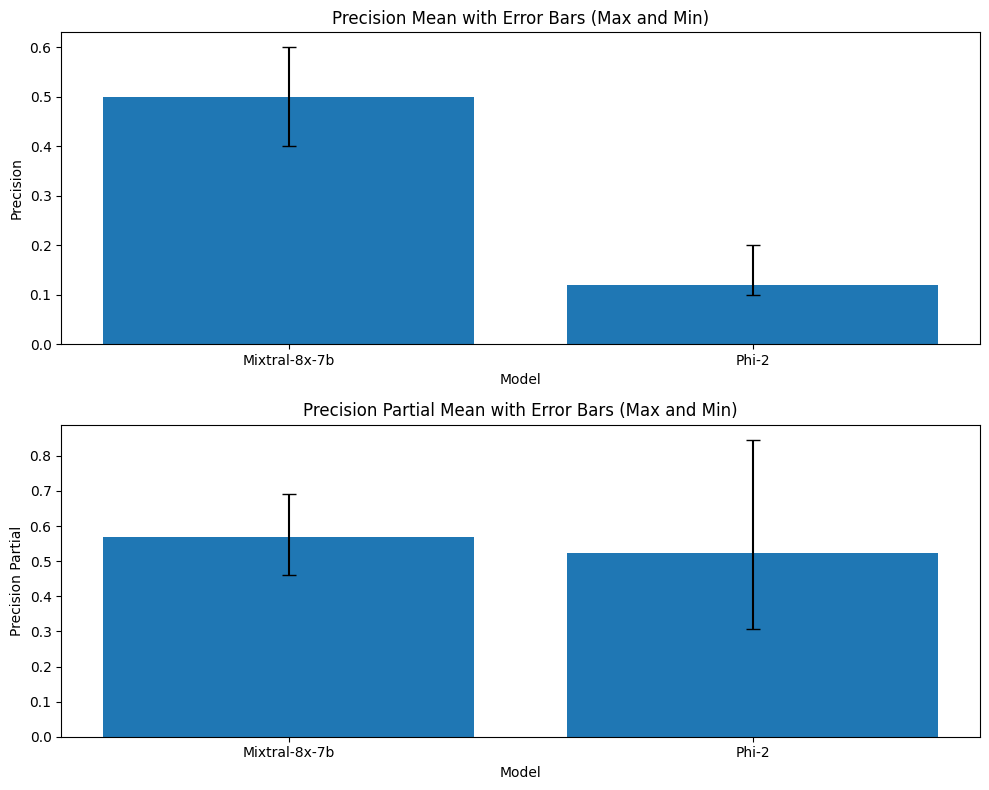

In [34]:

statistics_df = model_statistics
# Plotting
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot Precision Mean with error bars for Max and Min
axs[0].bar(statistics_df['Model'], statistics_df['Precision Mean'], yerr=[statistics_df['Precision Mean'] - statistics_df['Precision Min'], statistics_df['Precision Max'] - statistics_df['Precision Mean']], capsize=5)
axs[0].set_title('Precision Mean with Error Bars (Max and Min)')
axs[0].set_ylabel('Precision')
axs[0].set_xlabel('Model')

# Plot Precision Partial Mean with error bars for Max and Min
axs[1].bar(statistics_df['Model'], statistics_df['Precision Partial Mean'], yerr=[statistics_df['Precision Partial Mean'] - statistics_df['Precision Partial Min'], statistics_df['Precision Partial Max'] - statistics_df['Precision Partial Mean']], capsize=5)
axs[1].set_title('Precision Partial Mean with Error Bars (Max and Min)')
axs[1].set_ylabel('Precision Partial')
axs[1].set_xlabel('Model')

plt.tight_layout()
plt.show()